# Project: Identify Customer Segments

In this project, I have appled unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I have used has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.


In [1]:
!pip install missingno

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

# magic word for producing visualizations in notebook
%matplotlib inline


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I have used this information to cluster the general population into groups with similar demographic properties. Then, I have looked at how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.head())
print(azdias.shape)
print(azdias.describe())

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                     

In [6]:
print(feat_info.head())
print(feat_info.shape)

              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]
(85, 4)


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I have used this file to make cleaning decisions during this stage of the project. First of all, I have assessed the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. 
I have converted data that matches a 'missing' or 'unknown' value code into a numpy NaN value. 

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
# These data are naturally missing
print(azdias.isnull().sum())
print("Percentage of naturally missing values is ", azdias.isnull().sum() / azdias.count() * 100)

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [8]:
# Use the missing data feature column to sort missing values for each column
values = ['-1', '-3', '0','1','2','3','4','5','6','7','8','9']

for column in range(85): # loop over the column indexes
    missing = feat_info.iloc[column][3] # pull out the missing data codes for each column in the loop
    missing = missing.strip('[') # formatting
    missing = missing.strip(']') # formatting
    missing = missing.split(sep=',') # formatting
    for i in range(len(missing)): # loop over each code stored in missing
        if missing[i] in values: # if the code is in the values list
                missing[i] = int(missing[i]) # change to an integer
    if(missing!=['']): # if missing is not empty
        azdias = azdias.replace({feat_info.iloc[column][0]: missing}, np.nan) # replace with nan
        
print(azdias.head())

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                     

#### Step 1.1.2: Assess Missing Data in Each Column

Here I am checking how much missing data is present in each column. For this project, I have decided to remove columns with a lot of missing data from the dataframe. 


In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data = (azdias.isnull().sum() / len(azdias) * 100).sort_values(ascending=False)
print(missing_data)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

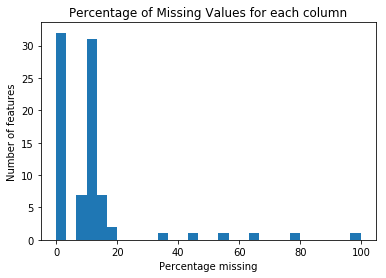

In [10]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_data, bins=30)
plt.title("Percentage of Missing Values for each column");
plt.ylabel("Number of features");
plt.xlabel("Percentage missing");

This plot shows that the majority of columns/features have less than 20% missing data, so we can keep those features for further analyses. However some features have up to 100% missing data and so we will drop those features as they will not be helpful in analysis. 

In [11]:
# Remove features with more than 30% missing data
to_drop = pd.DataFrame(missing_data[missing_data > 30])
to_keep = pd.DataFrame(missing_data[missing_data < 30])
to_keep_list = to_keep.index
azdias_dropped = azdias[to_keep_list]
print(azdias_dropped.shape)

(891221, 79)


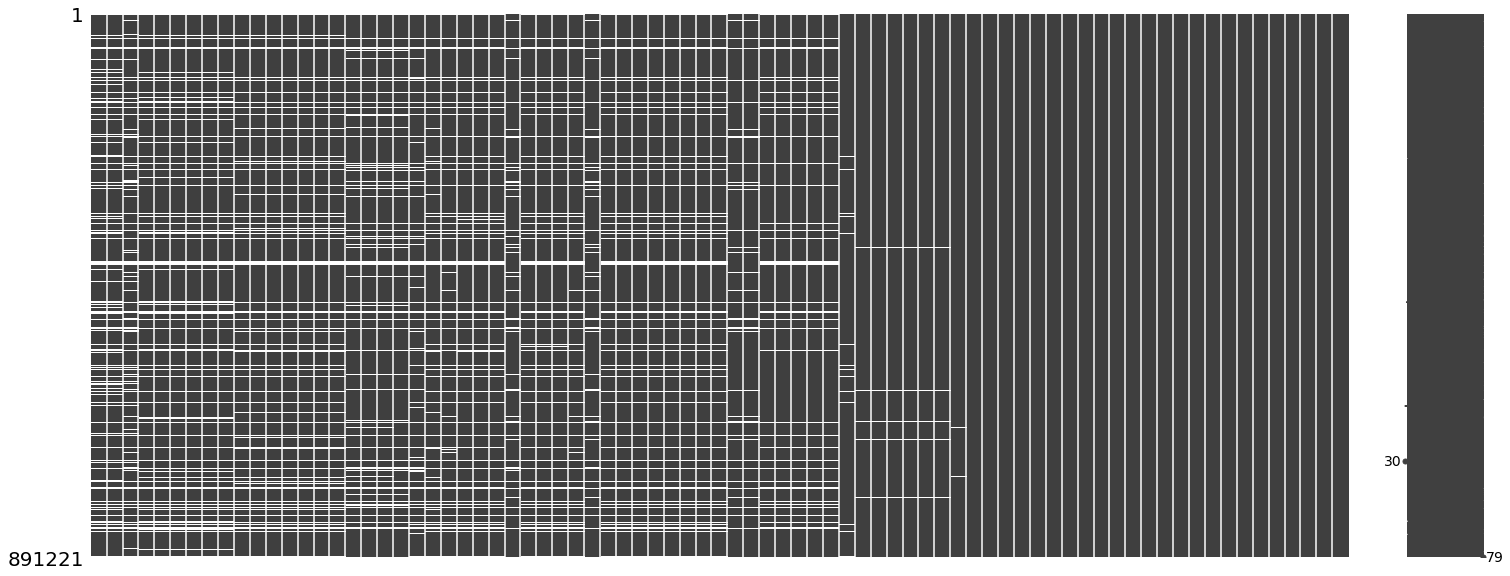

In [12]:
# Visualise patterns in missing data to get an idea of whether they are related
import missingno as msno
msno.matrix(azdias_dropped)
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

It looks as though quite a lot of the missing data is missing consistently across different fields. This probably means that there is a systematic reason for it e.g. some sets of data were not collected on certain dates.


In [13]:
print("This field has been dropped from the dataset " + to_drop.index)

Index(['This field has been dropped from the dataset TITEL_KZ',
       'This field has been dropped from the dataset AGER_TYP',
       'This field has been dropped from the dataset KK_KUNDENTYP',
       'This field has been dropped from the dataset KBA05_BAUMAX',
       'This field has been dropped from the dataset GEBURTSJAHR',
       'This field has been dropped from the dataset ALTER_HH'],
      dtype='object')


#### Step 1.1.3: Assess Missing Data in Each Row

I have performed a similar assessment for the rows of the dataset to find out how much data is missing in each row? 

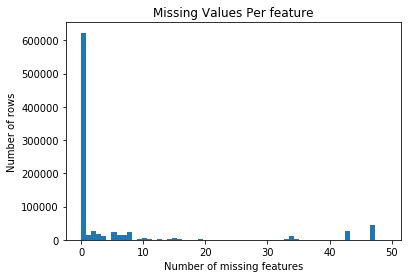

In [14]:
# How much data is missing in each row of the dataset?
plt.hist(azdias_dropped.isnull().sum(axis=1),bins=60)
plt.title("Missing Values Per feature");
plt.ylabel("Number of rows");
plt.xlabel("Number of missing features");

In [15]:
# divide the data into two subsets based on the number of missing values in each row.
missing_vals_row = azdias_dropped.isnull().sum(axis=1)
high_missing_vals = azdias_dropped[azdias_dropped.isnull().sum(axis=1) > 2]
low_missing_vals = azdias_dropped[azdias_dropped.isnull().sum(axis=1) <= 2]

print(low_missing_vals.shape)
print(high_missing_vals.shape)

(666873, 79)
(224348, 79)


In [16]:
print(feat_info.shape)
print(low_missing_vals.shape)

(85, 4)
(666873, 79)


In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Find the columns where there are no missing values
no_missing = []
for i in range(79):
    if(missing_data[i]==0):
        no_missing.append(missing_data.index[i])
no_missing    

['FINANZTYP',
 'GREEN_AVANTGARDE',
 'FINANZ_HAUSBAUER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_ANLEGER',
 'FINANZ_SPARER',
 'FINANZ_MINIMALIST',
 'ANREDE_KZ',
 'FINANZ_VORSORGER',
 'SEMIO_FAM',
 'SEMIO_SOZ',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT']

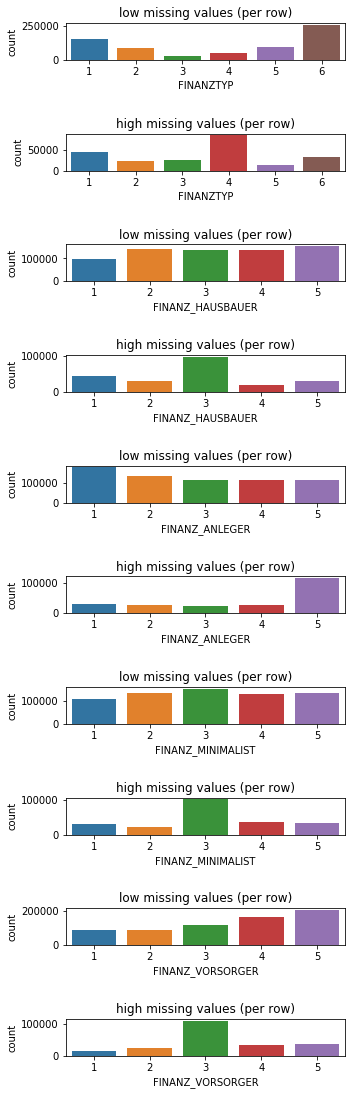

In [18]:
fig, axs = plt.subplots(10, figsize=(5,19)) # create 10 subplots and set size of the plots
fig.subplots_adjust(hspace = 2, wspace=.2)
for i in range(10):
    if(i%2==0):
        sns.countplot(low_missing_vals[no_missing[i]], ax=axs[i])
        axs[i].set_title('low missing values (per row)')
        sns.countplot(high_missing_vals[no_missing[i]], ax=axs[i+1])
        axs[i+1].set_title('high missing values (per row)')
    continue


#### Discussion 1.1.3: Assess Missing Data in Each Row

There does appear to be a different distribution of data for the low missingness and high missingness subsets of the data. For example, looking at the FINANZ_VORSORGER feature shows that in the high missingness group the majority of data is coded with the value 3, this pattern is not replicated in the low missingness subset and in fact those data are more skewed towards values 4 and 5. This might suggest a reason for missingness of other features, however this would require further exploration and expert knowledge on each feature and their relationships. 

### Step 1.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I have made a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. The third column of the feature summary (`feat_info`) provides a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.


In [19]:
# How many features are there of each data type e.g. binary, categorical?
features = list(low_missing_vals.columns)
feat_info = feat_info[feat_info.attribute.isin(features)]
print(feat_info.type.value_counts(dropna=False))
print(feat_info.shape)
print(low_missing_vals.shape)


ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64
(79, 4)
(666873, 79)


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, they have been kept without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, I have re-encoded the values as numbers.
- For multi-level categoricals (three or more values), I have kept things simple by removing them from the analysis.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat = feat_info[feat_info['type'] == 'categorical']
print(cat)

# Make a subset of cat data, and view possible values
binary = []
categorical = []

for col in list(cat['attribute']):
    if len(low_missing_vals[col].value_counts()) > 2:
        categorical.append(col)
    else:
        binary.append(col)
        


           attribute information_level         type missing_or_unknown
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
41          VERS_TYP            person  categorical               [-1]
42    

In [21]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Check which of the binary variables need to be re-encoded
print(low_missing_vals[binary].head())

   ANREDE_KZ  GREEN_AVANTGARDE  SOHO_KZ  VERS_TYP OST_WEST_KZ
1          2                 0      1.0       2.0           W
2          2                 1      0.0       1.0           W
4          1                 0      0.0       2.0           W
5          2                 0      0.0       2.0           W
6          2                 0      0.0       1.0           W


In [22]:
# # Because the column named 'OST_WEST_KZ' is non-numerical it needs to be re-encoded

# Re-encode to 0 and 1
low_missing_vals.loc[:, 'OST_WEST_KZ'] = low_missing_vals.apply(lambda x : 1 if x['OST_WEST_KZ'] == 'W' else (0 if x['OST_WEST_KZ'] == 'O' else x), axis=1)
low_missing_vals.OST_WEST_KZ.value_counts(dropna=False)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1    522103
0    144770
Name: OST_WEST_KZ, dtype: int64

In [23]:
# Drop multi-level categorical data, for simplicity
for col in categorical:
    low_missing_vals=low_missing_vals.drop(col, axis=1)
    
print(low_missing_vals.shape)


(666873, 66)


In [24]:
# Update feat_info with the columns I have dropped
features = list(low_missing_vals.columns)
feat_info = feat_info[feat_info.attribute.isin(features)]
feat_info.type.value_counts(dropna=False)
print(feat_info.head())
print(feat_info.shape)
print(low_missing_vals.shape)


              attribute information_level         type missing_or_unknown
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]
5         FINANZ_SPARER            person      ordinal               [-1]
6      FINANZ_VORSORGER            person      ordinal               [-1]
(66, 4)
(666873, 66)


#### Discussion 1.2.1: Re-Encode Categorical Features

Of the binary categorical variables, only the OST_WEST_KZ column needed to be re-encoded as it was the only non-numeric encoding. I therefore used a lambda function to re-encode the values to 0's and 1's. 

For now I have decided to only use the binary data for the rest of the analysis, but I may wish to return to this later and see if the multi-level data can improve the modelling.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserved attention.
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I have created two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).


In [25]:
# subset the mixed types
mixed_types = feat_info[feat_info['type'] == 'mixed']['attribute']
low_missing_vals[mixed_types].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
1,21.0,6.0,14.0,4.0,51,1.0
2,3.0,1.0,15.0,2.0,24,1.0
4,32.0,10.0,8.0,3.0,43,2.0
5,8.0,2.0,3.0,7.0,54,1.0
6,2.0,1.0,10.0,5.0,22,1.0


FOR QUICK REFERENCE: PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Re-code the values and create a new column for decade
PRAEGENDE_JUGENDJAHRE_dict = {1:40, 2:40, 3:50,4:50,
                             5:60, 6:60, 7:60,8:70, 9:70,
                             10:80, 11:80, 12:80,13:80,
                             14:90, 15:90}
low_missing_vals['DECADE'] = low_missing_vals.PRAEGENDE_JUGENDJAHRE.map(PRAEGENDE_JUGENDJAHRE_dict)

print(low_missing_vals[['DECADE', 'PRAEGENDE_JUGENDJAHRE']].head())

   DECADE  PRAEGENDE_JUGENDJAHRE
1    90.0                   14.0
2    90.0                   15.0
4    70.0                    8.0
5    50.0                    3.0
6    80.0                   10.0


In [27]:
# Re-code the values and create a new column for movement.
PRAEGENDE_JUGENDJAHRE_dict2 = {1:1, 3:1, 5:1, 8:1, 10:1, 12:1,
                              14:1, 2:0, 4:0, 6:0, 7:0, 9:0, 11:0,
                              13:0, 15:0}


low_missing_vals['MOVEMENT'] = low_missing_vals.PRAEGENDE_JUGENDJAHRE.map(PRAEGENDE_JUGENDJAHRE_dict2)

print(low_missing_vals[['MOVEMENT', 'PRAEGENDE_JUGENDJAHRE']].head())   

low_missing_vals = low_missing_vals.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
   

   MOVEMENT  PRAEGENDE_JUGENDJAHRE
1       1.0                   14.0
2       0.0                   15.0
4       1.0                    8.0
5       1.0                    3.0
6       1.0                   10.0


In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables: WEALTH and LIFE_STAGE

# Split this variable into two separate columns for 10's and 1's e.g. 51, split into 5 and 1
string = list(low_missing_vals['CAMEO_INTL_2015'])
WEALTH = []
LIFE_STAGE = []

for i in range (len(string)):
    val=string[i]
    if(type(val)==str):
        WEALTH.append(int(val[0]))
    else:
        WEALTH.append(np.nan)

for i in range (len(string)):
    val=string[i]
    if(type(val)==str):
        LIFE_STAGE.append(int(val[1]))
    else:
        LIFE_STAGE.append(np.nan)

        
low_missing_vals['WEALTH'] = WEALTH
low_missing_vals['LIFE_STAGE'] = LIFE_STAGE
low_missing_vals = low_missing_vals.drop('CAMEO_INTL_2015', axis=1)
print(low_missing_vals.head())


   REGIOTYP  KKK  W_KEIT_KIND_HH  KBA05_ANTG4  KBA05_GBZ  MOBI_REGIO  \
1       3.0  2.0             3.0          2.0        1.0         1.0   
2       2.0  2.0             3.0          0.0        3.0         3.0   
4       5.0  3.0             2.0          0.0        3.0         3.0   
5       5.0  4.0             6.0          0.0        4.0         4.0   
6       5.0  3.0             3.0          0.0        3.0         5.0   

   KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  PLZ8_GBZ     ...      SEMIO_RAT  \
1          0.0          0.0          0.0       4.0     ...              6   
2          1.0          3.0          1.0       4.0     ...              4   
4          1.0          4.0          1.0       3.0     ...              2   
5          2.0          2.0          0.0       5.0     ...              7   
6          3.0          2.0          0.0       5.0     ...              7   

   SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  DECADE  \
1           4          7    

In [29]:
print(feat_info.shape)
print(low_missing_vals.shape)

(66, 4)
(666873, 68)


In [30]:
# Drop the other mixed data types
low_missing_vals = low_missing_vals.drop('LP_LEBENSPHASE_FEIN', axis=1)
low_missing_vals = low_missing_vals.drop('LP_LEBENSPHASE_GROB', axis=1)
low_missing_vals = low_missing_vals.drop('WOHNLAGE', axis=1)
print(low_missing_vals.shape)

(666873, 65)


#### Discussion 1.2.2: Engineer Mixed-Type Features

I have created four new columns which indicate the decade, political movement, wealth and life-stage. These columns take information from the 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' columns, but they are now in a format which is going to be useful for modelling. 

Other mixed-value features which I have dropped include: 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE'. This is because the ordering of the encoded variables does not really make sense and so they cannot be treated as ordinal variables, they are also quite complex to break down into different variables so I have decided to leave them out of the anaylsis for now. 

The final mixed variable PLZ8_BAUMAX is fine to leave as it will be treated as an ordinal variable because the ordering of the code makes sense to do this.


In [31]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Double check that we have low missing vals
print(low_missing_vals.isnull().sum(axis=1))
print(low_missing_vals.isnull().sum())

1         0
2         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
19        0
21        0
22        0
27        0
28        0
29        2
31        0
32        0
33        0
36        0
37        0
38        0
41        0
42        2
43        0
44        0
45        0
47        0
49        0
50        0
51        0
         ..
891183    0
891186    0
891188    0
891189    0
891190    0
891191    0
891192    0
891193    0
891194    0
891195    0
891196    0
891197    0
891198    0
891199    0
891200    0
891201    0
891202    0
891204    0
891205    0
891206    0
891207    0
891209    0
891210    0
891211    0
891212    0
891213    0
891214    0
891215    0
891219    0
891220    0
Length: 666873, dtype: int64
REGIOTYP                 27656
KKK                      27656
W_KEIT_KIND_HH            7421
KBA05_ANTG4                  0
KBA05_GBZ                    0
MOBI_REGIO                   0
KBA05_ANTG1                  0
KBA05_ANTG2           

### Step 1.3: Create a Cleaning Function

Since I need to perform the same cleaning steps on the customer demographics data, I have created a function below to execute the main feature selection, encoding, and re-engineering steps performed above. Then, when it comes to looking at the customer data in Step 3, I can run this function on that DataFrame to get the trimmed dataset in a single step.

In [33]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    for column in range(feat_info.shape[0]): # loop over the column indexes
        missing = feat_info.iloc[column][3] # pull out the missing data codes for each column in the loop
        missing = missing.strip('[') # formatting
        missing = missing.strip(']') # formatting
        missing = missing.split(sep=',') # formatting
        for i in range(len(missing)): # loop over each code stored in missing
            if missing[i] in values: # if the code is in the values list
                    missing[i] = int(missing[i]) # change to an integer
        if(missing!=['']): # if missing is not empty
            df = df.replace({feat_info.iloc[column][0]: missing}, np.nan) # replace with nan
        

    # Split the data into high and low missingness
    missing_vals_row = df.isnull().sum(axis=1)
    high = df[df.isnull().sum(axis=1) > 2]
    low = df[df.isnull().sum(axis=1) <= 2]
 
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    cat = feat_info[feat_info['type'] == 'categorical']
    print(cat)

    # Make a subset of categorical data
    binary = []
    categorical = []

    for col in list(cat['attribute']):
        if len(low[col].value_counts()) > 2:
            categorical.append(col)
        else:
            binary.append(col)
            
    # Re-encode 'OST_WEST_KZ' to 0 and 1
    low.loc[:, 'OST_WEST_KZ'] = low.apply(lambda x : 1 if x['OST_WEST_KZ'] == 'W' else (0 if x['OST_WEST_KZ'] == 'O' else x), axis=1)
    low.OST_WEST_KZ.value_counts(dropna=False)
    
    # Drop multi-level categorical data, for simplicity
    for col in categorical:
            low=low.drop(col, axis=1)

    # subset the mixed types
    mixed_types = feat_info[feat_info['type'] == 'mixed']['attribute']

    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    low['DECADE'] = low.PRAEGENDE_JUGENDJAHRE.map(PRAEGENDE_JUGENDJAHRE_dict)

    # re-code the values and create a new column for movement.
    low['MOVEMENT'] = low.PRAEGENDE_JUGENDJAHRE.map(PRAEGENDE_JUGENDJAHRE_dict2)

    low = low.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables: WEALTH and LIFE_STAGE

    # Split this variable into two separate columns for 10's and 1's e.g. 51, split into 5 and 1
    string = list(low['CAMEO_INTL_2015'])
    WEALTH = []
    LIFE_STAGE = []

    for i in range (len(string)):
        val=string[i]
        if(type(val)==str):
            WEALTH.append(int(val[0]))
        else:
            WEALTH.append(np.nan)

    for i in range (len(string)):
        val=string[i]
        if(type(val)==str):
            LIFE_STAGE.append(int(val[1]))
        else:
            LIFE_STAGE.append(np.nan)


    low['WEALTH'] = WEALTH
    low['LIFE_STAGE'] = LIFE_STAGE
    low = low.drop('CAMEO_INTL_2015', axis=1)
    
    # Drop the other mixed data types
    low = low.drop('LP_LEBENSPHASE_FEIN', axis=1)
    low = low.drop('LP_LEBENSPHASE_GROB', axis=1)
    low = low.drop('WOHNLAGE', axis=1)
    
    # remove selected columns and rows, ...
    # remove features with more than 30% missing data - these features were determined 
    # in the original dataset and 
    # so we are just selecting the same features here
    to_keep_list = list(low_missing_vals.columns)
    low = low[to_keep_list]
    
    # Return the cleaned dataframe.
    clean_data = low
    return clean_data

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before applying dimensionality reduction techniques to the data, I neededd to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

In [34]:
# Create impute and fill missing values with median
from sklearn.preprocessing import Imputer
imputer = Imputer()

imp = []
for x in sorted(low_missing_vals.columns.tolist()):
    imp.append(x)
low_missing_vals = low_missing_vals[imp]

low_missing_vals = pd.DataFrame(imputer.fit_transform(low_missing_vals), columns = low_missing_vals.columns)

print(low_missing_vals.isnull().sum())


# # Impute missing values with the median value
# col = list(low_missing_vals.columns)
# for i in range(len(col)):
#     median = low_missing_vals.iloc[:,i].median()
#     low_missing_vals.iloc[:,i] = low_missing_vals.iloc[:,i].fillna(median)

    
# print(low_missing_vals.isnull().sum())

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
ANZ_HAUSHALTE_AKTIV      0
ANZ_HH_TITEL             0
ANZ_PERSONEN             0
ANZ_TITEL                0
ARBEIT                   0
BALLRAUM                 0
DECADE                   0
EWDICHTE                 0
FINANZ_ANLEGER           0
FINANZ_HAUSBAUER         0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_UNAUFFAELLIGER    0
FINANZ_VORSORGER         0
GEBAEUDETYP_RASTER       0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
HH_EINKOMMEN_SCORE       0
INNENSTADT               0
KBA05_ANTG1              0
KBA05_ANTG2              0
KBA05_ANTG3              0
KBA05_ANTG4              0
KBA05_GBZ                0
KBA13_ANZAHL_PKW         0
KKK                      0
KONSUMNAEHE              0
LIFE_STAGE               0
                        ..
OST_WEST_KZ              0
PLZ8_ANTG1               0
PLZ8_ANTG2               0
PLZ8_ANTG3               0
PLZ8_ANTG4               0
PLZ8_BAUMAX              0
P

In [35]:
print(low_missing_vals[list(low_missing_vals.columns)].head())
print(low_missing_vals.head())

   ALTERSKATEGORIE_GROB  ANREDE_KZ  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0                   1.0        2.0                 11.0           0.0   
1                   3.0        2.0                 10.0           0.0   
2                   3.0        1.0                  3.0           0.0   
3                   1.0        2.0                  5.0           0.0   
4                   2.0        2.0                  4.0           0.0   

   ANZ_PERSONEN  ANZ_TITEL  ARBEIT  BALLRAUM  DECADE  EWDICHTE  \
0           2.0        0.0     3.0       6.0    90.0       3.0   
1           1.0        0.0     3.0       2.0    90.0       4.0   
2           4.0        0.0     4.0       2.0    70.0       5.0   
3           1.0        0.0     2.0       6.0    50.0       2.0   
4           1.0        0.0     4.0       6.0    80.0       4.0   

        ...        SEMIO_RAT  SEMIO_REL  SEMIO_SOZ  SEMIO_TRADV  SEMIO_VERT  \
0       ...              6.0        4.0        5.0          6.0         1.0   
1     

In [36]:
# Apply feature scaling to the general population demographics data.
# Fit and transform
scaler = StandardScaler()
low_missing_vals = pd.DataFrame(scaler.fit_transform(low_missing_vals), columns = low_missing_vals.columns)
print(low_missing_vals.head())

   ALTERSKATEGORIE_GROB  ANREDE_KZ  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0             -1.742284   0.974592             0.168652     -0.129522   
1              0.193020   0.974592             0.103553     -0.129522   
2              0.193020  -1.026070            -0.352138     -0.129522   
3             -1.742284   0.974592            -0.221940     -0.129522   
4             -0.774632   0.974592            -0.287039     -0.129522   

   ANZ_PERSONEN  ANZ_TITEL    ARBEIT  BALLRAUM    DECADE  EWDICHTE  \
0      0.171480  -0.060805 -0.188148  0.853627  1.162032 -0.567852   
1     -0.707385  -0.060805 -0.188148 -0.972294  1.162032  0.015740   
2      1.929210  -0.060805  0.817786 -0.972294 -0.218147  0.599331   
3     -0.707385  -0.060805 -1.194082  0.853627 -1.598326 -1.151443   
4     -0.707385  -0.060805  0.817786  0.853627  0.471943  0.015740   

        ...        SEMIO_RAT  SEMIO_REL  SEMIO_SOZ  SEMIO_TRADV  SEMIO_VERT  \
0       ...         1.293190   0.061639   0.395804     1.2534

### Discussion 2.1: Apply Feature Scaling

Because we have features that are on completely different scales it is essential to standardise the values. StandardScaler removes the means and scales to unit variance which is an appropriate method and results in all values being between 0 and 1. 

### Step 2.2: Perform Dimensionality Reduction

Below I have applied dimensionality reduction techniques.


In [37]:
# Apply PCA to the data.
pca = PCA()
low_pca = pca.fit(low_missing_vals)


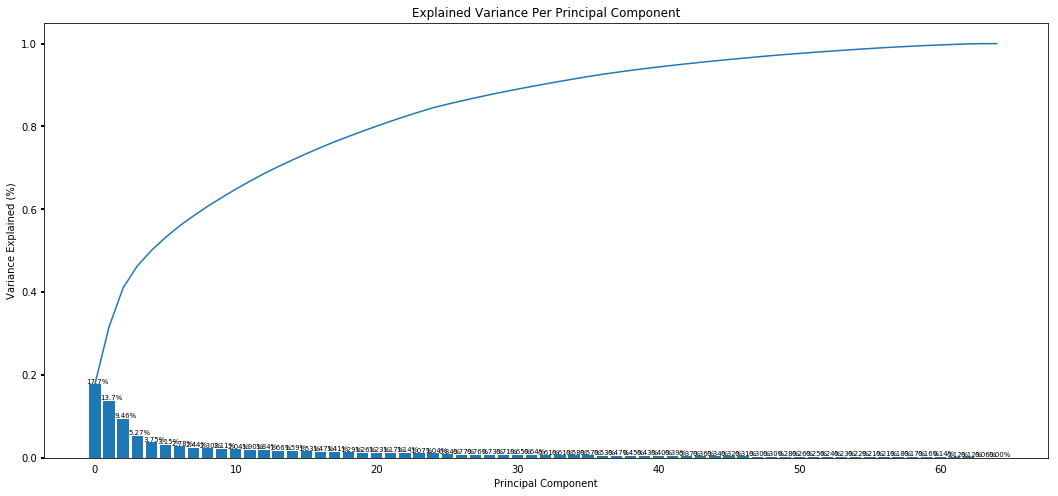

In [38]:
# Investigate the variance accounted for by each principal component.

## Note this function has been taken from the udacity helper functions provided.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=7)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=3)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

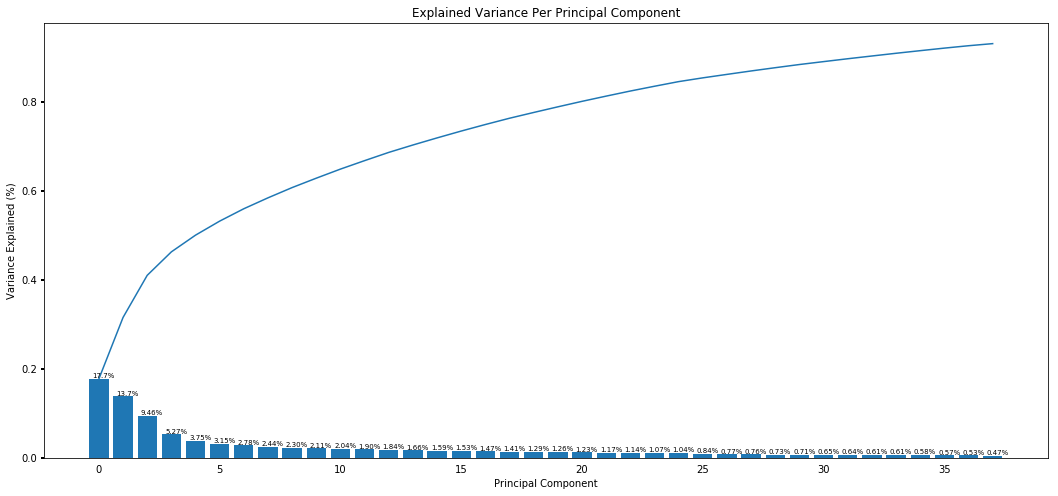

In [39]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 38)
low_missing_pca = pca.fit_transform(low_missing_vals)
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

I have fitted the PCA model and from looking at the scree plot I can see that 38 components is roughly optimal as 90% of the variance is explained with these components. 65 features have been retained to create these components.

### Step 2.3: Interpret Principal Components

Now that I have transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, I have mapped each weight to their corresponding feature name, then sorted the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. 

- I have investigated and interpreted feature associations from the first three principal components in this substep. To help facilitate this, I have written a function to call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

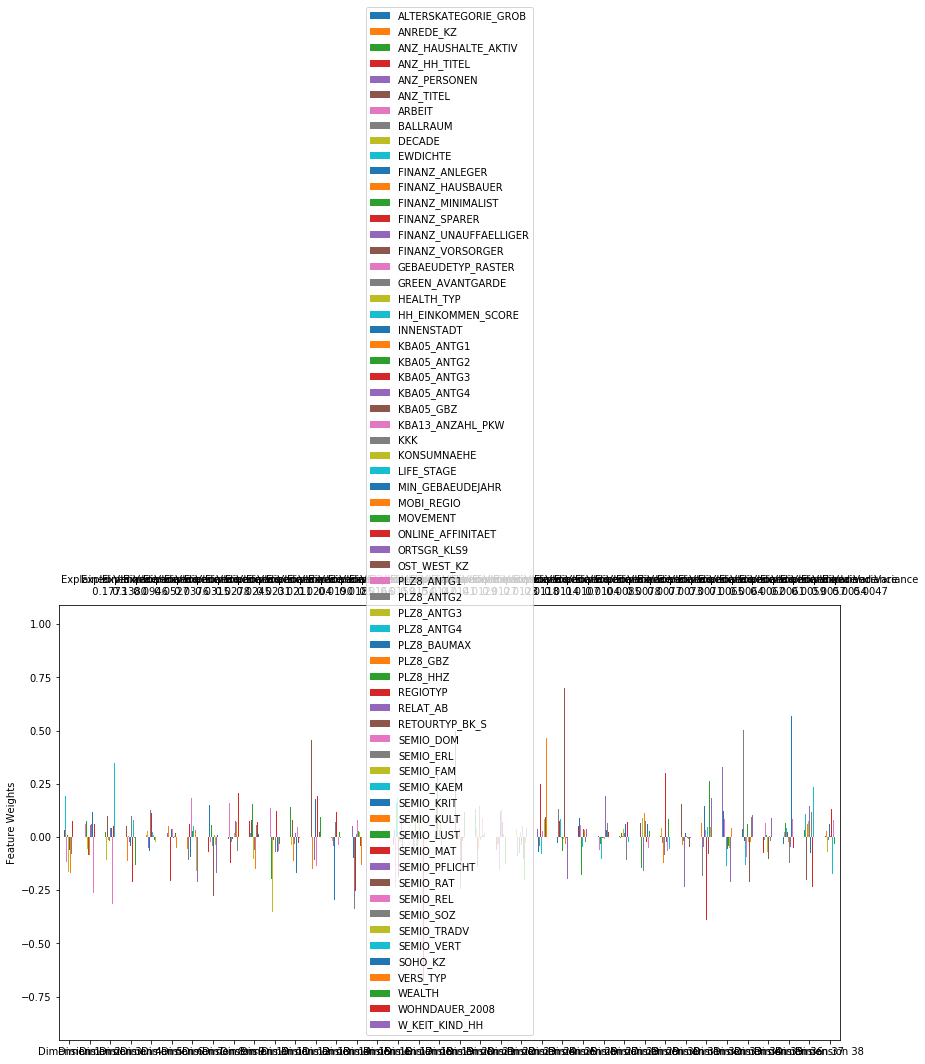

In [40]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.


# Note this function was taken from the helper functions provided by Udacity
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca_weights = pca_results(low_missing_vals, pca)

In [41]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(pca_weights.sort_values(by='Dimension 2', ascending=True, axis=1).head(2))


             SEMIO_REL  DECADE  FINANZ_SPARER  SEMIO_PFLICHT  SEMIO_TRADV  \
Dimension 1     0.1001  0.0958         0.1340         0.1031       0.0876   
Dimension 2    -0.2649 -0.2496        -0.2394        -0.2377      -0.2325   

             FINANZ_UNAUFFAELLIGER  SEMIO_KULT  FINANZ_ANLEGER  SEMIO_FAM  \
Dimension 1                 0.0668      0.0681          0.0573     0.0742   
Dimension 2                -0.2277     -0.2196         -0.2073    -0.1803   

             SEMIO_RAT          ...           SEMIO_KAEM  FINANZ_HAUSBAUER  \
Dimension 1     0.0859          ...               0.0329            0.1547   
Dimension 2    -0.1762          ...               0.1063            0.1093   

             W_KEIT_KIND_HH  SEMIO_KRIT  Explained Variance  RETOURTYP_BK_S  \
Dimension 1          0.0369      0.0036              0.1773         -0.0178   
Dimension 2          0.1171      0.1175              0.1380          0.1651   

             SEMIO_LUST  FINANZ_VORSORGER  SEMIO_ERL  ALTERSKAT

In [42]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(pca_weights.sort_values(by='Dimension 3', ascending=True, axis=1).head(3))


             ANREDE_KZ  SEMIO_KAEM  SEMIO_DOM  SEMIO_KRIT  SEMIO_RAT  \
Dimension 1     0.0013      0.0329     0.0180      0.0036     0.0859   
Dimension 2     0.0860      0.1063     0.0630      0.1175    -0.1762   
Dimension 3    -0.3690     -0.3388    -0.3139     -0.2710    -0.2159   

             FINANZ_ANLEGER  SEMIO_ERL  DECADE  FINANZ_SPARER  \
Dimension 1          0.0573    -0.0788  0.0958         0.1340   
Dimension 2         -0.2073     0.2332 -0.2496        -0.2394   
Dimension 3         -0.1865    -0.1710 -0.1068        -0.1021   

             FINANZ_UNAUFFAELLIGER     ...      ALTERSKATEGORIE_GROB  \
Dimension 1                 0.0668     ...                   -0.1136   
Dimension 2                -0.2277     ...                    0.2632   
Dimension 3                -0.0919     ...                    0.0821   

             W_KEIT_KIND_HH  Explained Variance  FINANZ_VORSORGER  \
Dimension 1          0.0369              0.1773           -0.1062   
Dimension 2          0.

### Discussion 2.3: Interpret Principal Components

The following variables are most important for dimension 2:
SEMIO_REL - negative for D2
ALTERSKATEGORIE_GROB = estimated age - positive for D2

So the dimension is made of older people with a higher affinity for SEMIO_REL.


The following variables are most important for dimension 3:
ANREDE_KZ = gender - negative for D3
SEMIO_VERT = positive for D3

So the dimension includes more females with a higher affinity for SEMIO_VERT.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I have assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I have applied k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.


In [ ]:
# Over a number of different cluster counts...
def get_kmeans_score(data, centre):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=centre)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    
    # compute the average within-cluster distances.
    averages = score/data.shape[0]

    return score, averages

scores = []
centres = list(range(1,11))
for centre in centres:
    scores.append(get_kmeans_score(low_missing_pca, centre))
    

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
plt.plot(centres, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Average distance from centroid');
plt.title('Scree plot');


In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=7)
model = kmeans.fit(low_missing_pca)
# score = np.abs(model.score(low_missing_vals))
general_kmeans = model.predict(low_missing_pca)

In [ ]:
print(model)
print(general_kmeans)

### Discussion 3.1: Apply Clustering to General Population

I have run k-means clustering with a selection of centroids ranging from 1-11 and plotted the average distance from the centre for each number of clusters. I decided 7 would be an optimal number of clusters, it might be slightly out from the "elbow", but there isn't a clear elbow in this plot as the average continues to decrease, albeit by small amount, with more clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that I have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. 

**NOTE** Be careful to not confuse this for re-fitting all of the models to the customer data. Instead, I am using the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, I have interpreted how the general population fits apply to the customer data.


In [ ]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')
print(customers.shape)

In [ ]:
# Clean up customers data
customers_low_missing_vals = clean_data(customers)
print(customers_low_missing_vals.shape)

In [ ]:
# Impute missing values with the median value - feature transformation
customers_imputer = imputer.transform(customers_low_missing_vals)
customers_low_missing_vals = pd.DataFrame(customers_imputer, columns = customers_low_missing_vals.columns)

print(customers_low_missing_vals.isnull().sum())


In [ ]:
# Scale data
customers_low_missing_vals[list(customers_low_missing_vals.columns)] = scaler.fit_transform(customers_low_missing_vals[list(customers_low_missing_vals.columns)])
print(customers_low_missing_vals.head())

In [ ]:
# Apply clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_pca = pca.transform(customers_low_missing_vals)
customers_kmeans = model.predict(customers_pca)


In [ ]:
# Counter(customers_kmeans[:,0])
print("General populations kmeans: ", general_kmeans)
print("Customers_kmeans: ", customers_kmeans)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I have compared the two cluster distributions to see where the strongest customer base for the company is.

I have considered the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.


In [ ]:
print(Counter(general_kmeans))
print(Counter(customers_kmeans))


In [ ]:
cust_proportion = cust_kmeans_df.groupby("cluster").count()/len(cust_kmeans_df)*100
general_proportion = general_kmeans_df.groupby("cluster").count()/len(general_kmeans_df)*100

diff = (cust_proportion - general_proportion)
diff.rename({'sample':'percentage difference'}, axis=1, inplace=True)
print(diff)

In [ ]:
# Compare the proportion of the overall dataset which has been assigned to each cluster 
# for the customer data and the general population.

cust_kmeans_df = pd.DataFrame()
cust_col = ["1"]
cust_kmeans_df["cluster"] = customers_kmeans
cust_kmeans_df["sample"] = cust_col*len(cust_kmeans_df)

general_kmeans_df = pd.DataFrame()
general_col = ["0"]
general_kmeans_df["cluster"] = general_kmeans
general_kmeans_df["sample"] = general_col*len(general_kmeans_df)

kmeans_df = pd.concat([cust_kmeans_df, general_kmeans_df])

# Plot counts for cluster data in both samples
sns.countplot(x='cluster', data=kmeans_df, hue='sample')

# Plot distributions
fig = plt.figure()
ax=fig.add_axes([0,0,2,1], title='Population vs Customer distribution plot')
sns.distplot(general_kmeans, label='population',ax=ax)
sns.distplot(customers_kmeans, label='customer', ax=ax)
ax.legend()

In [ ]:
# What kinds of people are part of a kmeans that is overrepresented in the
# customer data compared to the general population?

# vector of components, for cluster 0
pca_vector = model.cluster_centers_[0]
pca_cluster0_df = pd.DataFrame(pca_vector)
pca_cluster0_df["dimension"] = pca_cluster0_df.index +1
print(pca_cluster0_df.sort_values(by=[0], ascending=True))

Here we can see that components 11 and 3 have the greatest impact on cluster 0, which is overrepresented in customers

In [ ]:
## Check again the features that greatly contribute to those components
print(pca_weights.sort_values(by='Dimension 3', ascending=True, axis=1).head(3))
print(pca_weights.sort_values(by='Dimension 11', ascending=True, axis=1).head(11))


It looks like "ANREDE_KZ" and "SEMIO_VERT" are most important for component 3, and "HEALTH_TYP" and "W_KEIT_KIND_HH" are most important for component 11.

In [ ]:
# inverse transform the pca and features for cluster 0 - customers
non_scaled_cluster0 = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(customers_kmeans==0)])).round()
print(non_scaled_cluster0.shape)

customers_cluster0_df = pd.DataFrame(non_scaled_cluster0)
customers_cluster0_df.columns = customers_low_missing_vals.columns


In [ ]:
# inverse transform the pca and features for cluster 0 - general
general_non_scaled_cluster0 = scaler.inverse_transform(pca.inverse_transform(low_missing_pca[np.where(general_kmeans==0)])).round()
general_cluster0_df = pd.DataFrame(general_non_scaled_cluster0)
general_cluster0_df.columns = low_missing_vals.columns


In [ ]:
# Investigate the differences between customers and general
print("Differences in ANREDE_KZ between customers and general population")
print(customers_cluster0_df["ANREDE_KZ"].value_counts()/len(customers_cluster0_df)*100)
print(general_cluster0_df["ANREDE_KZ"].value_counts()/len(general_cluster0_df)*100)
print("Both customers and the general population are more likely to be male in this cluster")

print("Differences in SEMIO_VERT between customers and general population")
print(customers_cluster0_df["SEMIO_VERT"].value_counts()/len(customers_cluster0_df)*100)
print(general_cluster0_df["SEMIO_VERT"].value_counts()/len(general_cluster0_df)*100)
print("Both groups have a low affinity for SEMIO_VERT")

print("Differences in HEALTH_TYP between customers and general population")
print(customers_cluster0_df["HEALTH_TYP"].value_counts()/len(customers_cluster0_df)*100)
print(general_cluster0_df["HEALTH_TYP"].value_counts()/len(general_cluster0_df)*100)
print("Customers are more likely to be reserved and sanitary affine than the general population....whatever that means")


print("Differences in W_KEIT_KIND_HH between customers and general population")
print(customers_cluster0_df["W_KEIT_KIND_HH"].value_counts()/len(customers_cluster0_df)*100)
print(general_cluster0_df["W_KEIT_KIND_HH"].value_counts()/len(general_cluster0_df)*100)
print("Customers are more unlikley to have children living in their home than general population")




In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# vector of components, for cluster 2
pca_vector2 = model.cluster_centers_[2]
pca_cluster2_df = pd.DataFrame(pca_vector2)
pca_cluster2_df["dimension"] = pca_cluster2_df.index +1
print(pca_cluster2_df.sort_values(by=[0], ascending=True))


Here we can see that components 2 and 1 have the greatest impact on cluster 2, which is underrepresented in customers

In [ ]:
## Check again the features that greatly contribute to those components
print(pca_weights.sort_values(by='Dimension 2', ascending=True, axis=1).head(2))
print(pca_weights.sort_values(by='Dimension 1', ascending=True, axis=1).head(1))


It looks like "SEMIO_REL" and "ALTERSKATEGORIE_GROB" are most important for component 2, and "MOBI_REGIO" and "PLZ8_ANTG3" are most important for component 1.

In [ ]:
# inverse transform the pca and features for cluster 2 - customers
non_scaled_cluster2 = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(customers_kmeans==2)])).round()
print(non_scaled_cluster2.shape)

customers_cluster2_df = pd.DataFrame(non_scaled_cluster2)
customers_cluster2_df.columns = customers_low_missing_vals.columns


In [ ]:
# inverse transform the pca and features for cluster 0 - general
general_non_scaled_cluster2 = scaler.inverse_transform(pca.inverse_transform(low_missing_pca[np.where(general_kmeans==2)])).round()
general_cluster2_df = pd.DataFrame(general_non_scaled_cluster2)
general_cluster2_df.columns = low_missing_vals.columns


In [ ]:
# Investigate the differences between customers and general
print("Differences in SEMIO_REL between customers and general population")
print(customers_cluster2_df["SEMIO_REL"].value_counts()/len(customers_cluster2_df)*100)
print(general_cluster2_df["SEMIO_REL"].value_counts()/len(general_cluster2_df)*100)
print("Both customers and the general population are likely to have an overall lower affinity for SMEIO_REL, but customers may have slightly more people with a higher affinity")

print("Differences in ALTERSKATEGORIE_GROB between customers and general population")
print(customers_cluster2_df["ALTERSKATEGORIE_GROB"].value_counts()/len(customers_cluster2_df)*100)
print(general_cluster2_df["ALTERSKATEGORIE_GROB"].value_counts()/len(general_cluster2_df)*100)
print("Customers may be slightly older in this group")

print("Differences in MOBI_REGIO between customers and general population")
print(customers_cluster2_df["MOBI_REGIO"].value_counts()/len(customers_cluster2_df)*100)
print(general_cluster2_df["MOBI_REGIO"].value_counts()/len(general_cluster2_df)*100)
print("Customers have very high movement patterns, while general has high movement patterns, in general")

print("Differences in PLZ8_ANTG3_HH between customers and general population")
print(customers_cluster2_df["PLZ8_ANTG3"].value_counts()/len(customers_cluster2_df)*100)
print(general_cluster2_df["PLZ8_ANTG3"].value_counts()/len(general_cluster2_df)*100)
print("Customers are more likely to live in 6-10 person households")




### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 0 is overrepresented in the customer data compared to the general population. The cluster is driven by the following features: "ANREDE_KZ", "SEMIO_VERT", "HEALTH_TYP" and "W_KEIT_KIND_HH". Customers in cluster 0 tend to have less children and are more reserved.


Cluster 2 is underrepresented in the customer data compared to the general population. The cluster is driven by the following variables: "SEMIO_REL", "ALTERSKATEGORIE_GROB", "MOBI_REGIO" and "PLZ8_ANTG3". Customers in cluster 2 tend to have high movement patterns and live in larger households of 6-10 people, they may also be slightly older.

